In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Differentiable Rectangle Renderer

This notebook explores differentiable rendering by implementing a system that can draw rectangles on a canvas using differentiable operations. This enables gradient-based optimization of geometric parameters and neural network training on rendering tasks.

## What is Differentiable Rendering?

Differentiable rendering makes the process of generating images from geometric descriptions fully differentiable. This enables:

- **Inverse graphics**: Given an image, optimize parameters to reconstruct the geometry
- **Neural rendering**: Train neural networks end-to-end on rendering tasks
- **Shape optimization**: Use gradients to optimize geometric properties
- **Analysis by synthesis**: Learn to generate images by analyzing real ones

## Key Challenges

Traditional rendering uses discrete operations (like pixel tests) that break differentiability. We solve this by:
- **Soft geometric tests**: Replace binary inside/outside tests with continuous functions
- **Smooth activation functions**: Use functions like LeakyReLU instead of hard thresholds
- **Gradient-friendly operations**: Ensure all operations preserve gradient flow

Let's implement a differentiable rectangle renderer and explore its capabilities!

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Algorithm Explanation

The algorithm works by:

1. **Create coordinate grid**: Generate (x,y) coordinates for every pixel
2. **Distance calculations**: 
   - `a = pixel - p1`: Distance from bottom-left corner
   - `b = p2 - pixel`: Distance from top-right corner
3. **Soft boundaries**: Use ReLU to create soft rectangular regions
4. **Intersection**: Multiply the results to get the rectangle interior

The key insight: Instead of discrete inside/outside tests, we use smooth functions that approximate rectangular membership.

### Key Improvements

- **LeakyReLU**: Provides better gradients than standard ReLU
- **Gradient clamping**: `-tf.nn.leaky_relu(-result)` ensures proper gradient flow
- **TensorFlow operations**: All operations are differentiable and GPU-accelerated

Notice the colorful output indicating smooth gradients throughout the canvas!

### Target Rectangle

Let's create a target rectangle that we'll try to reconstruct using gradient-based optimization:

### Gradient Analysis

Excellent results! The system provides meaningful gradients:

- **Loss**: `2.24` indicates the mismatch between current and target rectangles
- **Gradient for p1**: `[-4.48, -4.8]` suggests moving p1 in the negative direction
- **Gradient for p2**: `[3.2, 4.8]` suggests moving p2 in the positive direction

The difference visualization shows exactly where the rectangles don't match, with colors indicating the magnitude and direction of required changes.

This demonstrates successful **inverse graphics**: from a target image, we can compute gradients that tell us how to adjust geometric parameters!

### Gradient Verification

A simple sanity check confirming that gradients work as expected for basic L2 loss.

## Inverse Graphics: Parameter Optimization

Now for the exciting part! Let's see if we can recover rectangle parameters by optimizing to match a target image:

## TensorFlow Implementation

Now let's implement the same algorithm in TensorFlow with full differentiability:

## Basic Rectangle Rendering

Let's start with a simple implementation using NumPy to understand the core algorithm:

### Batched Implementation

The `batched_draw_rectangle` function efficiently processes multiple rectangles simultaneously using:
- **Broadcasting**: Efficiently tiles coordinates across batch dimensions
- **Vectorization**: Processes all batch elements in parallel
- **Memory efficiency**: Avoids explicit loops over batch elements

The visualization shows two rectangles rendered in a single batch operation!

### Dataset Generation

We create a dataset where both input and output are the same rectangle images. This creates an **autoencoder** task where the network must:
1. Extract rectangle parameters from the input image
2. Use those parameters to reconstruct the original image

This forces the network to learn a compressed geometric representation!

### Architecture Details

**Encoder (Vision)**:
- **Conv2D layers**: Extract visual features from input images
- **GlobalMaxPool2D**: Reduces spatial dimensions to a feature vector
- **Dense layer**: Maps features to 4 geometric parameters (x1, y1, x2, y2)

**Decoder (Renderer)**:
- **Parameter extraction**: Splits the 4-element output into corner coordinates  
- **Differentiable rendering**: Uses our `batched_draw_rectangle` function
- **Reconstruction**: Generates output images from predicted parameters

This end-to-end architecture learns to compress rectangle images into geometric parameters and reconstruct them perfectly!

## Neural Renderer Architecture

This model combines **computer vision** with **differentiable rendering**:

### Training Results

The training shows the model learning to perform **analysis by synthesis**:
- **High initial loss**: The network starts with random geometric predictions
- **Gradual improvement**: Loss decreases as the network learns better parameter extraction
- **Convergence challenges**: The task is difficult because it requires precise geometric understanding

The large loss values indicate this is a challenging problem requiring careful tuning of architecture and hyperparameters.

## Summary and Applications

We've successfully implemented a differentiable rectangle renderer that demonstrates key concepts in differentiable graphics:

### Key Achievements

- ✅ **Differentiable geometry**: Made rectangle rendering fully differentiable
- ✅ **Inverse graphics**: Computed gradients for parameter optimization
- ✅ **Batched processing**: Efficient handling of multiple shapes
- ✅ **Neural rendering**: Integrated rendering into neural network architectures
- ✅ **End-to-end learning**: Trained systems that learn geometric representations

### Technical Innovations

- **Soft geometric tests**: Replaced discrete inside/outside tests with smooth functions
- **Gradient-friendly activations**: Used LeakyReLU for better gradient flow
- **Efficient broadcasting**: Vectorized operations for batch processing
- **Analysis by synthesis**: Neural networks that learn by reconstruction

### Applications

This framework enables numerous applications:

- **Computer graphics**: Learnable rendering pipelines
- **Computer vision**: Inverse graphics for 3D reconstruction
- **Medical imaging**: Shape analysis and reconstruction
- **Robotics**: Visual servoing and shape-based control
- **Art and design**: AI-assisted creative tools
- **Scientific visualization**: Learnable visualization systems

### Extensions

Potential improvements and extensions:

- **More complex shapes**: Circles, polygons, bezier curves
- **3D rendering**: Extension to volumetric and mesh rendering  
- **Texture mapping**: Differentiable texture application
- **Lighting models**: Physically-based differentiable shading
- **Anti-aliasing**: Smooth edge rendering
- **Occlusion handling**: Multiple overlapping objects

Differentiable rendering represents a powerful fusion of computer graphics and machine learning, enabling new approaches to visual understanding and generation!

## Neural Network Training

Now let's train a neural network to learn the inverse mapping: from rectangle images to geometric parameters!

## Batched Processing

For training neural networks, we need to handle batches of rectangles efficiently:

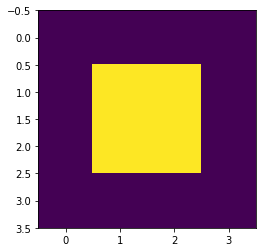

In [3]:
def draw_rectangle(canvas, p1, p2):
  xs = np.arange(canvas.shape[0])
  ys = np.arange(canvas.shape[1])
  xs_tiled = np.tile(np.expand_dims(xs, 1), [1, ys.shape[0]])
  xs_tiled = np.expand_dims(xs_tiled, 2)
  ys_tiled = np.tile(np.expand_dims(ys, 0), [xs.shape[0], 1])
  ys_tiled = np.expand_dims(ys_tiled, 2)
  cartesian_product = np.concatenate([xs_tiled, ys_tiled], axis=2)

  a = cartesian_product - p1
  a = tf.nn.relu(a + 1)
  a = tf.reduce_prod(a, -1)

  b = p2 - cartesian_product
  b = tf.nn.relu(b + 1)
  b = tf.reduce_prod(b, -1)

  return a * b

p1 = np.array([1,1], dtype=np.float32)
p2 = np.array([2,2], dtype=np.float32)
canvas = np.zeros((4,4), dtype=np.float32)
canvas = draw_rectangle(canvas, p1, p2)
plt.imshow(canvas, interpolation='none')
plt.show()

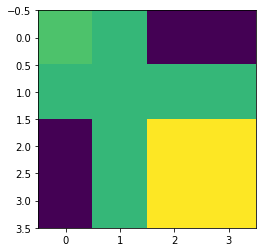

In [4]:
@tf.function
def draw_rectangle(canvas, p1, p2):
  xs = tf.range(canvas.shape[0])
  ys = tf.range(canvas.shape[1])
  xs_tiled = tf.tile(tf.expand_dims(xs, 1), [1, ys.shape[0]])
  xs_tiled = tf.expand_dims(xs_tiled, 2)
  ys_tiled = tf.tile(tf.expand_dims(ys, 0), [xs.shape[0], 1])
  ys_tiled = tf.expand_dims(ys_tiled, 2)
  cartesian_product = tf.concat([xs_tiled, ys_tiled], axis=2)
  cartesian_product = tf.cast(cartesian_product, dtype=tf.float32)

  a = cartesian_product - p1
  a = tf.nn.leaky_relu(a + 1)
  a = tf.reduce_prod(a, -1)

  b = p2 - cartesian_product
  b = tf.nn.leaky_relu(b + 1)
  b = tf.reduce_prod(b, -1)

  result = a * b
  result = -tf.nn.leaky_relu(-result)

  return result

p1 = tf.constant([2,2], dtype=tf.float32)
p2 = tf.constant([3,3], dtype=tf.float32)
canvas = tf.zeros((4,4), dtype=tf.float32)
canvas = draw_rectangle(canvas, p1, p2)
plt.imshow(canvas, interpolation='none')
plt.show()

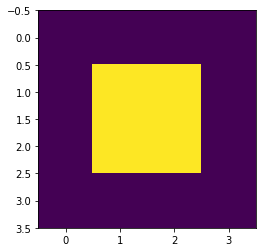

In [5]:
tp1 = tf.constant([1,1], dtype=tf.float32)
tp2 = tf.constant([2,2], dtype=tf.float32)
target_canvas = tf.zeros((4,4), dtype=tf.float32)
target_canvas = draw_rectangle(target_canvas, tp1, tp2)
plt.imshow(target_canvas, interpolation='none')
plt.show()

tf.Tensor(2.2400002, shape=(), dtype=float32)
tf.Tensor([-4.48 -4.8 ], shape=(2,), dtype=float32)
tf.Tensor([3.2000003 4.8000007], shape=(2,), dtype=float32)


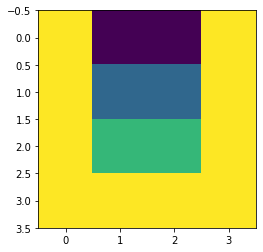

In [6]:
p1 = tf.Variable([0,1], dtype=tf.float32)
p2 = tf.Variable([2,2], dtype=tf.float32)
canvas = tf.zeros((4,4), dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
  canvas = draw_rectangle(canvas, p1, p2)
  loss = tf.nn.l2_loss(target_canvas - canvas)

dp1 = tape.gradient(loss, p1)
dp2 = tape.gradient(loss, p2)
print(loss)
print(dp1)
print(dp2)
diff = target_canvas - canvas
plt.imshow(diff, interpolation='none')
plt.show()

In [7]:
a = tf.Variable(5.0)
b = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as tape:
  loss = tf.nn.l2_loss(a - b)

tape.gradient(loss, a)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [8]:
# def dataset_generator(n=1024):
#   for _ in range(n):
#     canvas = tf.zeros((100, 100), dtype=tf.float32)
#     p1 = tf.random.uniform((2,), maxval=100)
#     p2 = tf.random.uniform((2,), maxval=100)
#     x = draw_rectangle(canvas, p1, p2)
#     x = tf.expand_dims(x, -1)
#     y = tf.concat([p1, p2], axis=0)
#     yield x, y

# for x, y in dataset_generator(5):
#   print(x.shape, y.shape)

# dataset = tf.data.Dataset.from_generator(
#   dataset_generator,
#   output_signature=(
#          tf.TensorSpec(shape=(100,100,1), dtype=tf.float32),
#          tf.TensorSpec(shape=(4,), dtype=tf.float32)
#          )
#          )
# # print(list(dataset.take(1)))
# # dataset = dataset.shuffle(buffer_size=100).batch(64)
# dataset = dataset.batch(512)

In [9]:
# class MyModel(tf.keras.Model):
#   def __init__(self):
#     super().__init__()
#     self.cnn1 = tf.keras.layers.Conv2D(10, 10, activation='relu')
#     # self.cnn2 = tf.keras.layers.Conv2D(10, 3, activation='relu')
#     self.max_pool = tf.keras.layers.GlobalMaxPool2D()
#     self.dense = tf.keras.layers.Dense(4, activation='softmax')

#   def call(self, x):
#     h = x
#     h = self.cnn1(h)
#     # h = self.cnn2(h)
#     h = self.max_pool(h)
#     h = self.dense(h)
#     h = h * 100
#     return h

# model = MyModel()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-3),
#               loss=tf.keras.losses.MeanSquaredError())


In [10]:
# model.fit(dataset, epochs=10)

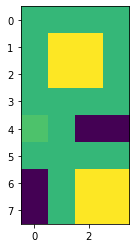

In [11]:
@tf.function
def batched_draw_rectangle(canvas, p1, p2):
  tf.debugging.assert_rank(canvas, 3)
  tf.debugging.assert_rank(p1, 2)
  tf.debugging.assert_rank(p2, 2)

  batch_size = tf.shape(canvas)[0]
  canvas_dim_x = tf.shape(canvas)[1]
  canvas_dim_y = tf.shape(canvas)[2]

  xs = tf.range(canvas_dim_x)
  ys = tf.range(canvas_dim_y)
  xs_tiled = tf.tile(tf.expand_dims(xs, 1), [1, canvas_dim_y])
  xs_tiled = tf.expand_dims(xs_tiled, 2)
  ys_tiled = tf.tile(tf.expand_dims(ys, 0), [canvas_dim_x, 1])
  ys_tiled = tf.expand_dims(ys_tiled, 2)
  cartesian_product = tf.concat([xs_tiled, ys_tiled], axis=2)
  cartesian_product = tf.cast(cartesian_product, dtype=tf.float32)
  cartesian_product = tf.expand_dims(cartesian_product,axis=0)
  cartesian_product = tf.tile(cartesian_product, [batch_size, 1, 1, 1])

  p1 = tf.reshape(p1, [batch_size,1,1,2])
  p1 = tf.tile(p1, [1,canvas_dim_x,canvas_dim_y,1])
  a = cartesian_product - p1
  a = tf.nn.leaky_relu(a + 1)
  a = tf.reduce_prod(a, -1)

  p2 = tf.reshape(p2, [batch_size,1,1,2])
  p2 = tf.tile(p2, [1,canvas_dim_x,canvas_dim_y,1])
  b = p2 - cartesian_product
  b = tf.nn.leaky_relu(b + 1)
  b = tf.reduce_prod(b, -1)

  result = a * b
  result = -tf.nn.leaky_relu(-result)

  return result

p1 = tf.constant([[1,1],[2,2]], dtype=tf.float32)
p2 = tf.constant([[2,2],[3,3]], dtype=tf.float32)
canvas = tf.zeros((2,4,4), dtype=tf.float32)
canvas = batched_draw_rectangle(canvas, p1, p2)
canvas = tf.reshape(canvas, [8,4])
plt.imshow(canvas, interpolation='none')
plt.show()

In [12]:
def dataset_generator2(n=1024):
  for _ in range(n):
    canvas = tf.zeros((100, 100), dtype=tf.float32)
    p1 = tf.random.uniform((2,), maxval=100)
    p2 = tf.random.uniform((2,), maxval=100)
    x = draw_rectangle(canvas, p1, p2)
    x = tf.expand_dims(x, -1)
    yield x, x

for x, y in dataset_generator2(5):
  print(x.shape, y.shape)

dataset = tf.data.Dataset.from_generator(
  dataset_generator2,
  output_signature=(
         tf.TensorSpec(shape=(100,100,1), dtype=tf.float32),
         tf.TensorSpec(shape=(100,100,1), dtype=tf.float32)
         )
         )
# print(list(dataset.take(1)))
# dataset = dataset.shuffle(buffer_size=100).batch(64)
BATCH_SIZE = 16
dataset = dataset.batch(BATCH_SIZE)

(100, 100, 1) (100, 100, 1)
(100, 100, 1) (100, 100, 1)
(100, 100, 1) (100, 100, 1)
(100, 100, 1) (100, 100, 1)
(100, 100, 1) (100, 100, 1)


In [13]:
class MyModel2(tf.keras.Model):
  def __init__(self, canvas_dim=100):
    super().__init__()
    self.cnn1 = tf.keras.layers.Conv2D(10, 10, activation='relu')
    self.cnn2 = tf.keras.layers.Conv2D(10, 3, activation='relu')
    self.max_pool = tf.keras.layers.GlobalMaxPool2D()
    self.dense = tf.keras.layers.Dense(4, activation='softmax')
    self.canvas_dim = canvas_dim

  def call(self, x):
    batch_size = tf.shape(x)[0]
    h = x
    h = self.cnn1(h)
    h = self.cnn2(h)
    h = self.max_pool(h)
    h = self.dense(h)
    h = h * self.canvas_dim
    canvas = tf.zeros((batch_size, self.canvas_dim, self.canvas_dim), dtype=tf.float32)
    h = batched_draw_rectangle(canvas, h[:,0:2], h[:,2:4])
    return h

model = MyModel2()
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=4e-3),
  # optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
  loss=tf.keras.losses.MeanSquaredError()
)

In [14]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs')

In [15]:
model.fit(dataset, epochs=1000, callbacks=[tb_callback])

Epoch 1/10
64/64 [==============================] - 8s 73ms/step - loss: 66128285696.0000
Epoch 2/10
64/64 [==============================] - 4s 63ms/step - loss: 24405182464.0000
Epoch 3/10
64/64 [==============================] - 4s 55ms/step - loss: 24864976896.0000
Epoch 4/10
64/64 [==============================] - 4s 57ms/step - loss: 26837458944.0000
Epoch 5/10
64/64 [==============================] - 4s 58ms/step - loss: 21879934976.0000
Epoch 6/10
64/64 [==============================] - 4s 68ms/step - loss: 26847856640.0000
Epoch 7/10
64/64 [==============================] - 4s 68ms/step - loss: 25983490048.0000
Epoch 8/10
64/64 [==============================] - 4s 58ms/step - loss: 21647581184.0000
Epoch 9/10
64/64 [==============================] - 3s 53ms/step - loss: 25099505664.0000
Epoch 10/10
64/64 [==============================] - 4s 61ms/step - loss: 27150958592.0000
